# Exploration des tendances de Youtube en France

### Simplification du JSON des catégories

Les catégories de vidéo sont données sous forme d'un fichier JSON assez peu pratique à exploiter. Nous allons dans un premier temps simplifier ce fichier.

In [1]:
import json

#Studied country
country_code = "FR"

with open("youtube/"+country_code+"_category_id.json") as json_data:
    data_dict = json.load(json_data)
    with open("youtube/"+country_code+"_category_id.csv",'w') as csv_cat:
        csv_cat.write("id,category_title\n")
        for category in data_dict["items"]:
            csv_cat.write(category["id"])
            csv_cat.write(",")
            csv_cat.write(category["snippet"]["title"])
            csv_cat.write("\n")
        

Maintenant, nous avons uniquement dans un fichier csv l'id et le nom de chaque catégorie, ce qui est bien plus pratique.

## Exploration des données

On fusionne les fichiers csv videos et categorie afin d'avoir le titre de categorie pour chaque vidéo.

In [2]:
import pandas as pd

videos_csv = "youtube/"+country_code+"videos.csv"
categories_csv = "youtube/"+country_code+"_category_id.csv"

videos = pd.read_csv(videos_csv)
categories = pd.read_csv(categories_csv)

#We merge the 2 dataframes in order to have the category title for each video:
videos = videos.merge(categories, left_on='category_id', right_on='id',how='left')
videos.drop(["id"],axis=1,inplace=True)

Dans un premier temps, regardons les statistiques pour chaque champ du dataset:

In [3]:
videos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40724 entries, 0 to 40723
Data columns (total 17 columns):
video_id                  40724 non-null object
trending_date             40724 non-null object
title                     40724 non-null object
channel_title             40724 non-null object
category_id               40724 non-null int64
publish_time              40724 non-null object
tags                      40724 non-null object
views                     40724 non-null int64
likes                     40724 non-null int64
dislikes                  40724 non-null int64
comment_count             40724 non-null int64
thumbnail_link            40724 non-null object
comments_disabled         40724 non-null bool
ratings_disabled          40724 non-null bool
video_error_or_removed    40724 non-null bool
description               37812 non-null object
category_title            40610 non-null object
dtypes: bool(3), int64(5), object(9)
memory usage: 4.8+ MB


In [4]:
videos["channel_title"].value_counts()

Troom Troom FR                        195
Elhiwar Ettounsi                      181
sam zirah                             173
Lama Faché                            171
Marodi TV Sénégal                     169
VikatanTV                             167
Touche pas à mon poste !              157
Çukur                                 151
Topito                                150
RadaanMedia                           147
Lolywood                              143
THIRU TV                              139
Attessia TV                           137
France Inter                          134
WatchMojo Français                    133
Un gars une fille | Officiel          128
BRICO SYMPA                           128
Dr Nozman                             125
Okay.africa                           124
NDEKO ELIEZER TOKOKOMA                123
Zap Télé                              120
Ça Zap !                              114
Wass Freestyle                        112
TVLibertés                        

On peut également observer les différentes statistiques pour les champs numériques:

In [5]:
videos.describe()

category_id         views         likes      dislikes  comment_count
count  40724.000000  4.072400e+04  4.072400e+04  4.072400e+04   4.072400e+04
mean      20.123809  4.199219e+05  1.738886e+04  8.149624e+02   1.832453e+03
std        6.984422  1.772130e+06  8.720509e+04  1.139219e+04   1.404321e+04
min        1.000000  2.230000e+02  0.000000e+00  0.000000e+00   0.000000e+00
25%       17.000000  1.697450e+04  3.380000e+02  1.800000e+01   5.600000e+01
50%       23.000000  7.372100e+04  1.892500e+03  8.300000e+01   2.350000e+02
75%       24.000000  2.708088e+05  7.969500e+03  3.350000e+02   8.410000e+02
max       44.000000  1.009116e+08  4.750254e+06  1.353661e+06   1.040912e+06

On peut s'étonner que certaines vidéos en tendance ont un nombre de like, dislike ou de commentaires nul. Cela vient probablement du fait que certains vidéos désactivent ces fonctionnalités.

### Visualisation

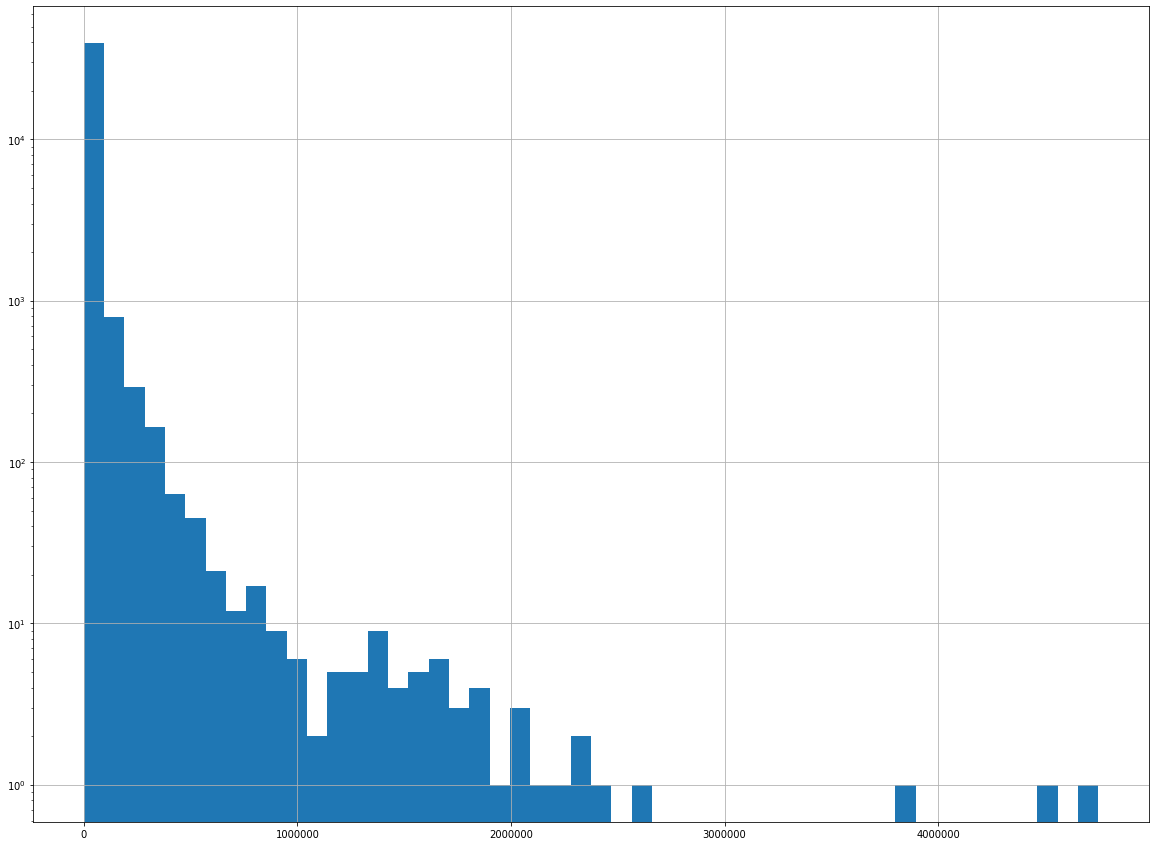

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

videos["likes"].hist(bins=50, log=True,figsize=(20,15))
plt.show()

Il semble qu'un grand nombre de vidéos aient un nombre de likes proche de 0.   
Il est possible que les vidéos ayant désactivés la fonctionnalité nous induisent en erreur. Il faudrait donc retracer le graphe sans ces données.

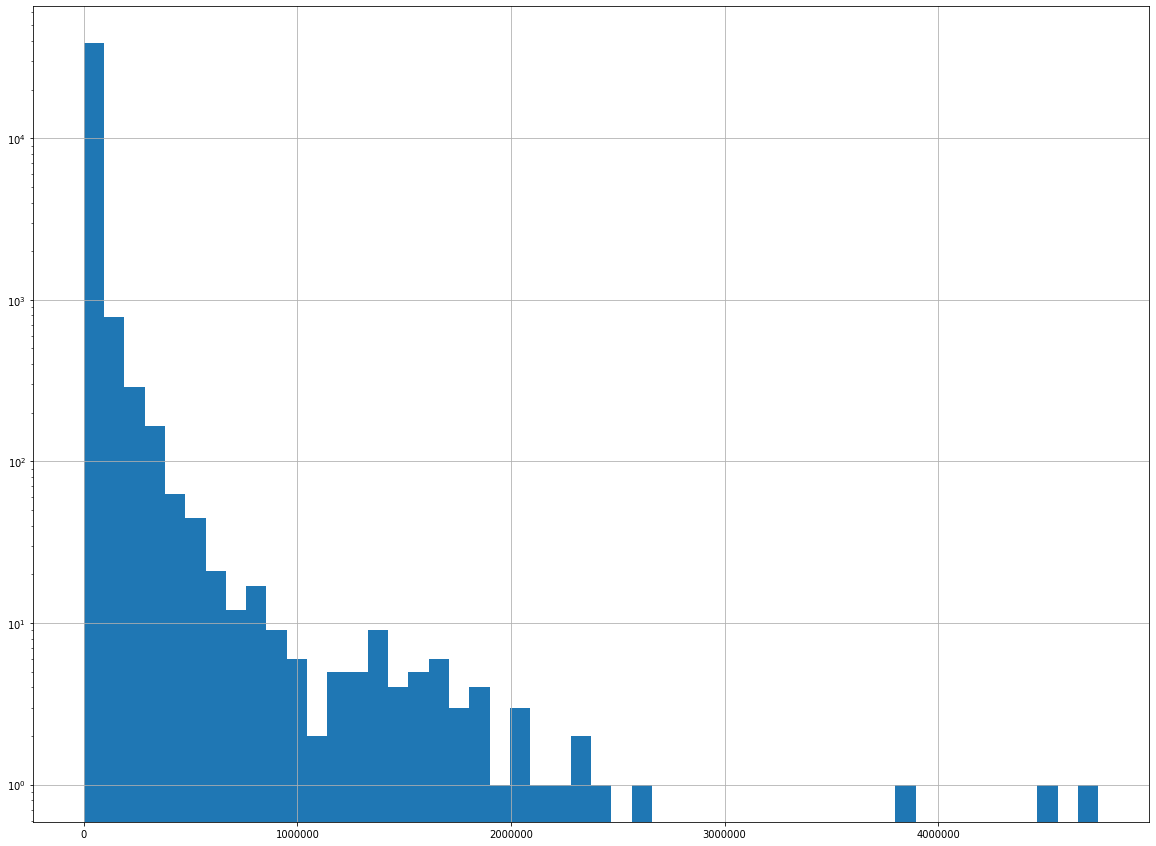

In [7]:
videos[videos["ratings_disabled"] == False]["likes"].hist(bins=50, log=True,figsize=(20,15))
plt.show()

Enlever les vidéos ayant désactiver les likes ne change pas l'allure de l'histogramme.  
**On observe donc que la majorité des vidéos en tendance ont un nombre de likes très faible.**

## Les catégories en tendance

Dans un premier temps, pour simplifier les choses, 
dessinons le graphique du nombre de vidéos par categorie.

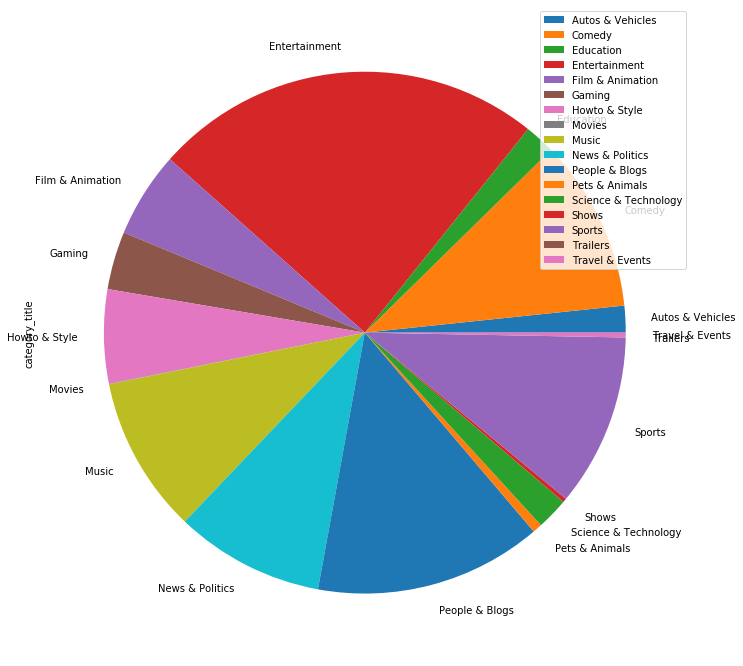

In [66]:
categories_stat = pd.DataFrame(videos["category_title"].value_counts())
categories_stat.sort_index(inplace=True)
categories_stat.plot.pie(y="category_title", figsize=(12, 12))

En terme de nombre de vidéos, c'est les catégories relatives au divertissement qui l'emportent haut la main.

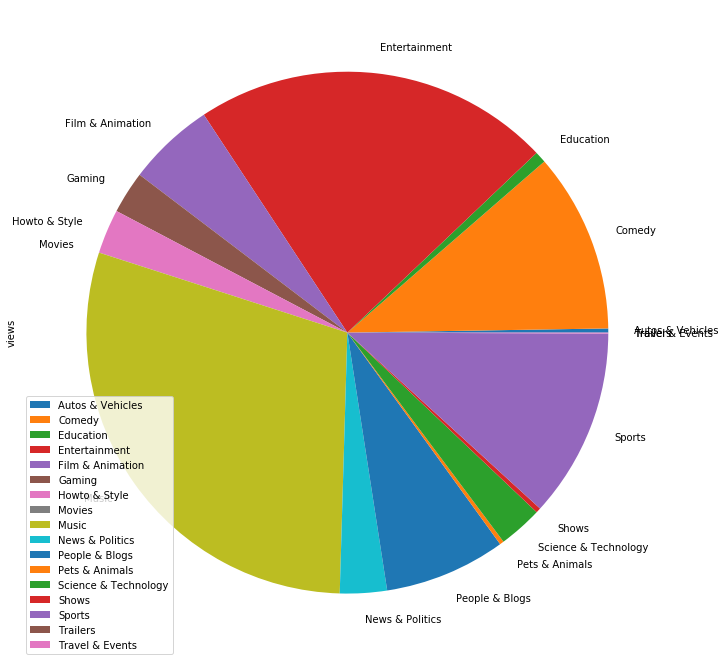

In [67]:
view_per_category = videos[['category_title','views']].groupby('category_title').sum()
view_per_category.plot(x="category_title",y="views",kind="pie", figsize=(12, 12))

Le graphique en terme de vue par catégorie ressemble fortement au précédent. Toutefois, on remarque que la proportion de la catégorie musique a presque triplé sur ce nouveau graphique.   
Cela vient certainement du fait que les vidéos de musique, laissées en arrière plan, sont naturellement regardées un plus grand nombre de fois.    
De façon inverse, les vidéos sur la politique sont nombreuses et accumulent un faible nombre de vues.

# Ratio de Like/Dislike par categorie

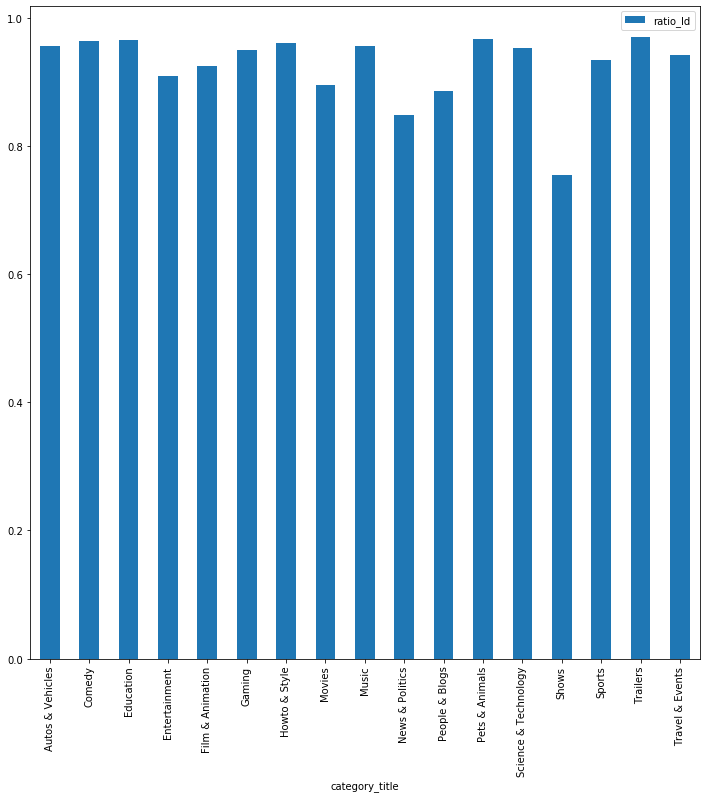

In [72]:
videos["ratio_ld"] = videos["likes"] / (videos["likes"]+videos["dislikes"])
ratio_ld_per_category = videos[['category_title','ratio_ld']].groupby('category_title').mean()
ratio_ld_per_category.plot(y="ratio_ld",kind="bar", figsize=(12, 12))

En moyenne, la majorité des catégories de vidéo sont très appreciés par leur spectateurs. Seul la catégorie "Shows" semble présenter un nombre de dislike plus grand que les autres catégories.

Pour voir les catégories qui déchainent le plus les passions, il peut être interessant d'étudier la valeur min pour chaque catégorie:

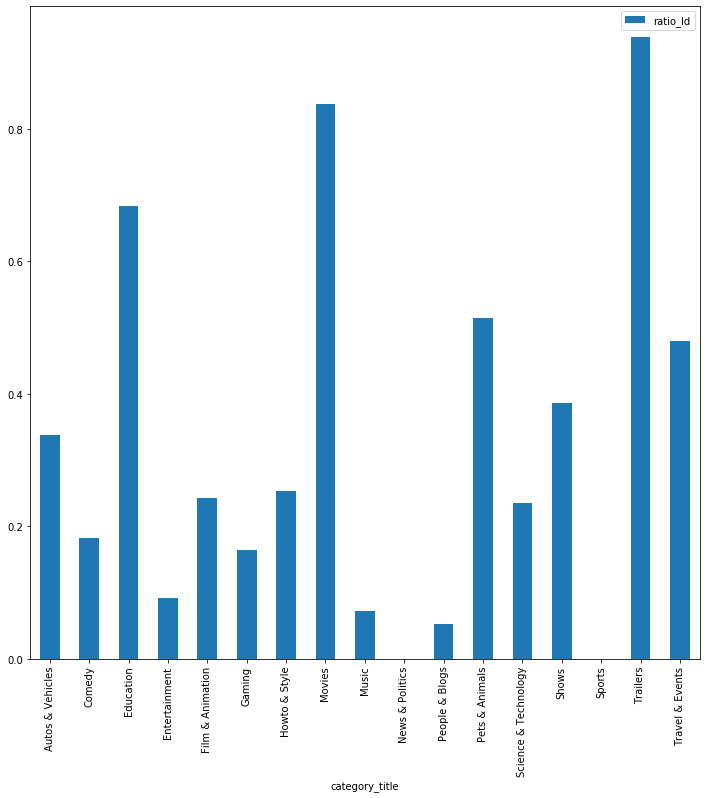

In [73]:
ratio_ld_per_category_min = videos[['category_title','ratio_ld']].groupby('category_title').min()
ratio_ld_per_category_min.plot(y="ratio_ld",kind="bar", figsize=(12, 12))

La plupart des catégories donnent lieu à des vidéos très detestées. On remarque toutefois que certaines categories donnent lieu à moins de haine comme "Education", "Movies" ou "Trailers".

## Du Machine Learning pour prédire le succès d'une vidéo ?

Avec ce Dataset, on aimerait être capable d'entrainer un modèle de ML pour prédire le succès d'une vidéo. Malheuresement, les données ne sont pas adaptées.    
En effet, on souffrirait du biais du survivant. En effet, en ayant accès qu'aux vidéos ayant eu un relatif succès et pas à celle étant passées inapercues, on pourrait identifier à tort des critères de succès.
Pour mener à bien cet exercice, **il faudrait un dataset avec des vidéos tirées aleatoirement sur Youtube, populaires ou pas.**